[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/subhacom/moose-notebooks/blob/main/Simple_chemical_bistable.ipynb) [![Binder](./binder_logo.png)](https://mybinder.org/v2/gh/MooseNeuro/moose-notebooks/HEAD?labpath=Simple_chemical_bistable.ipynb)

In [1]:
## Only required on colab! Uncomment to enable.
# !pip install pymoose --quiet

# Stability and chemical reactions

*Note: This is based on the simple bistables example by Upi Bhalla, available as a script in moose-examples/tutorials/ChemicalBistables/simpleBis.py.*

If you gently drop a ball in a bowl, it will roll around a bit and then settle at the bottom. If you nudge it a bit, it will roll back to that position. If we consider the position of the ball to represent its state, then the bottom of the bowl is its steady state. 

![A ball inside a bowl has a single stable position](media/images/simple_chemical_bistable/stability_monostable.svg "Figure 1")

*Figure 1. Stability in a monostable system: If you release a ball on the inside of a bowl, it will roll around for some time and then settle at the bottom. If you nudge it a bit, it will roll back to the same position. This is the stable position of the ball in the bowl. There being a single stable position, this is a monostable system.*

We can build bistable systems using a set of chemical reactions. Another example of a bistable system is a light switch. It can be either on or off. If you turn it on, it stays on. It does not turn off on its own. To turn it off, you need to push it (an external stimulus). And once turned off, it stays off. The positions of the switch are its states. Although it transitions from "on" to "off" state (and the other way) through a continuous path, if you leave it half way, it jumps to either "on" or "off" position. Also, if you nudge the switch a little bit without going all the way, it jumps back to the state where it was. Thus, "on" and "off" are the two *stable* states of the system. All the intermediate states are unstable. This is an example of a bistable mechanical system.

![A ball placed on the ridge can go into one two stable positions](media/images/simple_chemical_bistable/stability_bistable.png "Figure 2")

*Figure 2. Illustration of bistable systems. Left: A ball placed on the ridge can roll down either side, and settle at the bottom of the valley on that side. Small perturbations, like a gentle nudge, can move the ball a bit, but it will roll back to the same position. However, a large push can give it enough energy to roll over the ridge and go to the other side. Then it would settle at the bottom of the valley on that side: the other stable point. Right: A light switch with "ON" and "OFF" states is a real life example of a bistable system.*

Something similar can be done with chemistry. Here the states could be represented by the concentrations of chemicals. Say you have two chemicals $A$ and $B$ in a beaker, one at high concentration and the other at low concentration. Also imagine, $B$ is an enzyme that is produced from $A$ by autocatalysis:

$A \xrightarrow{B} B$

and another enzyme $C$ converts $B$ back to $A$:

$A \xleftarrow{C} B$

Together the reaction scheme is:
$A \xrightleftharpoons[C]{B} B$

Depending on the initial concentrations, these reactions reach a dynamic equilibrium where the concentrations of $A$ and $B$ reach steady levels, representing a "steady state" of the reaction system. For example, high $[A]$ and low $[B]$.


In [2]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

import moose

## Create containers for model and data

In [3]:
# Containers - we create 'model' and 'data' containers inside /container, 
# deleting it first if it already exists. Otherwise existing objects will
# be reused in the simulation, leading to errors

cpath = '/container'

if moose.exists(cpath):
    moose.delete(cpath)
moose.Neutral(cpath)
    
model = moose.Neutral(f'{cpath}/model')
data = moose.Neutral(f'{cpath}/data')




## Setup chemical compartment for the reaction

In [4]:
# Setup chemical compartment for the reaction

comp = moose.CubeMesh(f'{model.path}/comp')   # Chemical compartment
comp.volume = 1e-21 # m^3

# Get a handle to the mesh created automatically by the compartment
mesh = moose.element(f'{comp.path}/mesh' ) 

## Create molecules and reactions

In [5]:
# Create molecules and reactions

# Pools are the molecule-pools for substrates, products, and enzymes
a = moose.Pool(f'{comp.path}/a')
b = moose.Pool(f'{comp.path}/b')
c = moose.Pool(f'{comp.path}/c')

# Create the enzymatic reaction objects
enz1 = moose.Enz(f'{comp.path}/b/enz1')
enz2 = moose.Enz(f'{comp.path}/c/enz2')

# Create molecule pools representing enzyme-substrate complex
cplx1 = moose.Pool(f'{comp.path}/b/enz1/cplx')
cplx2 = moose.Pool(f'{comp.path}/c/enz2/cplx')

## Connect up the the molecules and enzymes and the reaction object

In [6]:
# Connect them up for reactions ...

# Connect enzymatic reaction enz1 to its molecule pools
moose.connect(enz1, 'sub', a, 'reac')  # a is the substrate molecule pool for enz1 (b)
moose.connect(enz1, 'prd', b, 'reac')  # b is the product molecule pool for enz1 
moose.connect(enz1, 'enz', b, 'reac')  # b is also the enzyme molecule pool for enz1
moose.connect(enz1, 'cplx', cplx1, 'reac')   # cplx1 is the enzyme-substrate complex pool for enz1

# Connect enzymatic reaction enz2 to its molecule pools
moose.connect(enz2, 'sub', b, 'reac')   # b is the substrate molecule pool for enz2 (c)
moose.connect(enz2, 'prd', a, 'reac')   # a is the product molecule pool for enz2 
moose.connect(enz2, 'enz', c, 'reac')   # c is the enzyme molecule pool for enz2
moose.connect(enz2, 'cplx', cplx2, 'reac')  # cplx2 is the enzyme-substrate complex pool for enz2

<moose.SingleMsg id=5 dataIndex=7 path=/Msgs[0]/singleMsg[7]>

# Set up tables to accummulate simulated concentrations

In [7]:
# Create the output tables
outputA = moose.Table2(f'/{data.path}/concA')
outputB = moose.Table2(f'{data.path}/concB')

# connect up the tables
moose.connect(outputA, 'requestOut', a, 'getConc')
moose.connect(outputB, 'requestOut', b, 'getConc')

<moose.SingleMsg id=5 dataIndex=9 path=/Msgs[0]/singleMsg[9]>

Up to this point was just setting up the model structure. This part should be run only once. If you want to modify the structure, then start from top where we delete the container first, so that you have a clean slate. Otherwise each rerun of `moose.connect()` with the same two objects will keep adding more connections, essentially changing the order of the reaction.

## Setup stoichiometric solver

Now we setup the stoichiometry solver of class `Ksolve`. This is mass-action based solver which assumes the number of molecules to be large enough that the stochasticity in the chemical reaction can be ignored.


In [8]:
stoich = moose.Stoich(f'{comp.path}/stoich')
stoich.compartment = moose.element(f'{comp.path}')
ksolve = moose.Ksolve(f'{comp.path}/ksolve')
stoich.ksolve = ksolve
stoich.reacSystemPath = f'{comp.path}/##'


## Assign parameters
Below we set the initial concentration and $k_{cat}$ and $K_{m}$ for the enzymes, and $K_{f}$ and $K_{b}$ of the reaction.

In [9]:
# Assign parameters
a.concInit = 1
b.concInit = 0
c.concInit = 0.01
enz1.kcat = 0.4
enz1.Km = 4
enz2.kcat = 0.6
enz2.Km = 0.01


## Run the simulation
Now we will initialize the model.

In [10]:
moose.reinit()

check the dt of the solver:

In [11]:
print(ksolve.dt)

0.1


which is 0.1, and thus slow enough for this simulation without too many unnecessary steps ... and run the simulation for 100 s.

In [12]:
moose.start( 100.0 ) # Run the model for 100 seconds.

## Plot the data

Finally we can plot the concentrations $[A]$ and $[B]$  against time

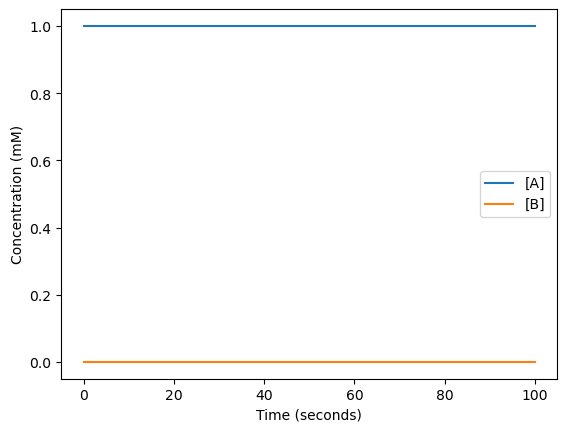

In [13]:
t = np.arange(len(outputA.vector)) * outputA.dt
plt.plot(t, outputA.vector, label='[A]')
plt.plot(t, outputB.vector, label='[B]')
plt.xlabel('Time (seconds)')
plt.ylabel('Concentration (mM)')
plt.legend()

## Perturb the system and continue simulation

It appears that there is hardly any change in $[A]$ and $[B]$. Now we will manipulate the system by swapping A and B. First we will convert 90% of A into B. So $[B]$ will increase by $0.9 \times [A]$, and the $[A]$ will become $0.1 \times [A]$.

*Note that we did not call `reinit()` here! This is because we want to continue the simulation from where it ended.*

In [14]:
# move most molecules over to b
b.conc = b.conc + a.conc * 0.9
a.conc = a.conc * 0.1
moose.start( 100.0 ) # Run the model for 100 seconds.


Now we can plot the accumulated results again:

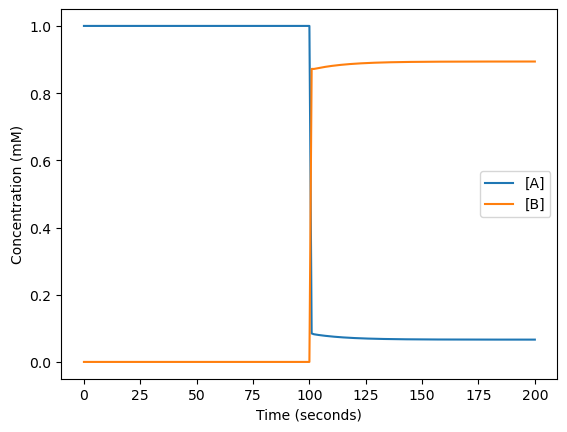

In [15]:
t = np.arange(len(outputA.vector)) * outputA.dt
plt.plot(t, outputA.vector, label='[A]')
plt.plot(t, outputB.vector, label='[B]')
plt.xlabel('Time (seconds)')
plt.ylabel('Concentration (mM)')
plt.legend()

As you can see, once we flipped A and B, the concentrations stabilize to different levels. We can flip them again! 

This time, we will convert 99% of B into A, and run the simulation for another 100 s.

In [16]:
# move most molecules back to a
a.conc = a.conc + b.conc * 0.99
b.conc = b.conc * 0.01
moose.start( 100.0 ) # Run the model for 100 seconds.


... and plot the accumulated data again ...

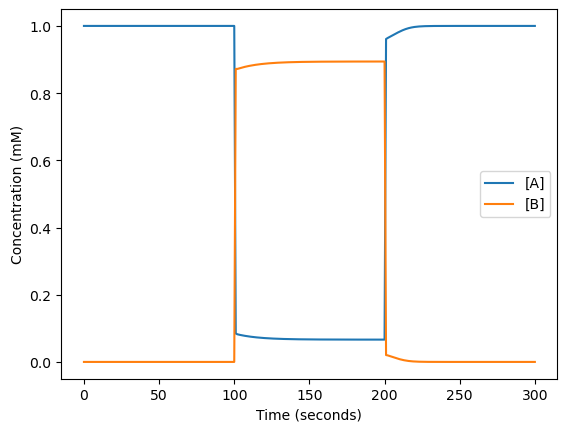

In [17]:
t = np.arange(len(outputA.vector)) * outputA.dt
plt.plot(t, outputA.vector, label='[A]')
plt.plot(t, outputB.vector, label='[B]')
plt.xlabel('Time (seconds)')
plt.ylabel('Concentration (mM)')
plt.legend()

Thus, when we perturb the dynamic equilibrium, it settles at a new stable pair concentrations.

# Exercises

1. Change the initial concentration of B (`b.concInit`) to 0.1 mM in the "Assign parameters" step, and rerun the rest of this notebook. What do you observe?
2. Change the initial concentration of C to 0.4 mM. How does the system behave now?
3. Now take a range of values of initial concentration of A and note down what you observe.